#  Problem Statement 1: Trade Logic & Risk Control Basics


### 1. What does leverage less than 1 mean? Does it normally make financial sense? Think of its utility/applicability in our backtesting engine, if any. (Hint: Think of position sizing)



Use less than 1 refers to the utilization of less than half of the available capital in opening a position. An example is in 0.5x leverage, where you utilize ₹500 out of ₹1000 capital—basically slashing position size. This may sound conservative, but it can be financially sensible in risk-averse or diversified strategies.

In backtesting, this is useful for simulating partial capital deployment or portfolio-level position sizing, where only a portion of capital is committed to each signal. It helps test realistic capital allocation models and controls maximum drawdown across multiple trades or strategies. Hence, leverage < 1 is not useless—it represents conservative position size allocation

###  2. Explain the difference between a static stop loss and a trailing stop loss in the context of trade risk management. Discuss how each behaves in a trending market versus a volatile market.

**A static stop-loss (SSL)** is a fixed price level set when entering a trade. For example, if you buy a stock at ₹100 with a 10% static stop-loss, you set your SL at ₹90. This value does not change, regardless of how the market moves.

**A trailing stop-loss (TSL)**, in contrast, is a dynamic risk control tool that adjusts as the price moves in your favor. It maintains a fixed percentage (or value) gap from the highest price reached. If the stock moves from ₹100 → ₹110 → ₹120, and the TSL is 10%, your stop-loss moves from ₹90 → ₹99 → ₹108. If the price then drops to ₹115, the stop-loss remains at ₹108 and the trade closes only if price hits it.

 **Behavior in Different Market Conditions:**

**1. Trending Market**

  Static SL:
   Can exit lately even after significant upward movement. For example, if price hits ₹130 but falls back to original SL at ₹90, the trade exits at a loss, missing the profit window which it could exit earlier with profit rather than exiting lately with ₹10 loss.
   
Trailing SL:
Adjusts upwards with price. If price hits ₹130, the TSL moves to ₹117. Even if the price then reverses, it exits at a profit.

Hence, **TSL is better suited for trending markets**.

**2. Volatile Market**

Static SL:
Remains unaffected by small ups and downs. Offers more stability and avoids frequent exits due to noise.

Trailing SL:
May trigger often due to small price dips, resulting in frequent premature exits and potentially missing out on a bigger move.

Hence, **Static SL is often more effective in volatile environments.**



###  3. Analyze whether implementing a trailing take profit is necessary. Is its behavior captured by some other already defined risk management method? If yes, then name it.

A Trailing Take Profit (TTP) is a method where you let profits grow as the stock price rises, but you exit the trade automatically if the price falls by a certain amount. For example, if you buy a stock at ₹100 and it rises to ₹120, a trailing take profit might exit the trade if the price drops 10% from the peak (i.e., to ₹108). This helps lock in profits without manually watching the trade.

However, this behavior is already handled by a Trailing Stop Loss (TSL). A TSL also moves up as the stock price goes up and stays fixed if the price drops. It not only protects from loss when the trade goes against you, but also protects profits once the trade is in your favor.

So, a separate trailing take profit is not necessary. The Trailing Stop Loss already covers both roles — it limits losses early and locks in profits later.

###  4. In what scenarios can a trade remain open even after the price falls below the set stop-loss level?



A trade can remain open even after the price falls below the stop-loss level due to several real-world factors.

* **Slippage**, when the market moves too rapidly for the stop-loss to sell at the very same level. For instance, if the price just fell from ₹91 to ₹87, the stop-loss at ₹90 gets skipped, and the trade stays alive until the broker can sell at a cheaper price.
* **Gap-down Opening**, when the market opens well below the stop-loss point, like from ₹100 to ₹85 overnight. Under these circumstances, stop-loss is hit, but the trade closes at ₹85, not ₹90, and is kept open throughout that gap.
* **Low liquidity**,if there are not sufficient buyers or sellers at the stop-loss level, the order won't be filled right away.
* **Backtesting**, assuming you're using daily candles and the stop-loss is triggered intraday but the candle closes above the stop-loss, the system will wrongly assume that the trade is still open.


#  Problem Statement 2: Probabilistic Pattern Validator

In [1]:
!pip install yfinance --quiet

# Import libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# For better plots
sns.set(style="whitegrid")


In [2]:
# Download 5 years of daily data for an NSE stock (Here TCS is Taken)
ticker = 'TCS.NS'
df = yf.download(ticker, period="5y", interval="1d")
df = df.dropna().reset_index()

# Handle MultiIndex columns by accessing the first level and converting to lowercase
if isinstance(df.columns, pd.MultiIndex):
    df.columns = [col[0].lower() if isinstance(col, tuple) else col.lower() for col in df.columns]

else:
    # If not a MultiIndex, just convert to lowercase
    df.columns = [col.lower() for col in df.columns]

display(df.head())

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


,date,close,high,low,open,volume
0,2020-06-15,1827.581055,1853.780652,1801.516419,1835.864052,2399022
1,2020-06-16,1841.895996,1867.240209,1828.571062,1859.182296,2146528
2,2020-06-17,1843.696899,1853.645596,1824.564876,1842.076261,2703527
3,2020-06-18,1834.963379,1853.960328,1823.349095,1841.175681,1944389
4,2020-06-19,1840.815796,1881.690824,1829.471653,1838.474958,5681758


### 1. Pattern Identification:

In [3]:
# Doji: Open ≈ Close (very small body)
def is_doji(row, threshold=0.001):
    return abs(row['close'] - row['open']) / (row['high'] - row['low'] + 1e-6) < threshold

# Hammer: Small body, long lower shadow
def is_hammer(row):
    body = abs(row['close'] - row['open'])
    lower_shadow = row['open'] - row['low'] if row['close'] > row['open'] else row['close'] - row['low']
    upper_shadow = row['high'] - row['close'] if row['close'] > row['open'] else row['high'] - row['open']
    return lower_shadow > 2 * body and upper_shadow < body

# Bullish Engulfing: green candle fully engulfs previous red candle
def is_bullish_engulfing(curr, prev):
    return (
        prev['close'] < prev['open'] and
        curr['close'] > curr['open'] and
        curr['close'] > prev['open'] and
        curr['open'] < prev['close']
    )


In [4]:
# For Applying pattern detection
doji_indices = df[df.apply(is_doji, axis=1)].index.tolist()
hammer_indices = df[df.apply(is_hammer, axis=1)].index.tolist()
engulfing_indices = [i for i in range(1, len(df)) if is_bullish_engulfing(df.iloc[i], df.iloc[i - 1])]

# To show number of pattern occurrences
print(f"Doji patterns found: {len(doji_indices)}")
print(f"Hammer patterns found: {len(hammer_indices)}")
print(f"Engulfing patterns found: {len(engulfing_indices)}")


Doji patterns found: 5
Hammer patterns found: 40
Engulfing patterns found: 44


### 2. Win-Rate Calculation:

In [5]:
# Win rate function for all patterns
def calculate_win_rate(indices, n):
    wins = 0
    total = 0
    for idx in indices:
        if idx + n < len(df):
            entry_price = df.loc[idx, 'close']
            future_price = df.loc[idx + n, 'close']
            if future_price > entry_price:
                wins += 1
            total += 1
    return (wins / total) * 100 if total > 0 else 0

# Calculate pattern win rates for n = 3 and 5
pattern_results = []

for n in [3, 5]:
    pattern_results.append({
        'n': n,
        'Pattern': 'Doji',
        'Win Rate': calculate_win_rate(doji_indices, n)
    })
    pattern_results.append({
        'n': n,
        'Pattern': 'Hammer',
        'Win Rate': calculate_win_rate(hammer_indices, n)
    })
    pattern_results.append({
        'n': n,
        'Pattern': 'Engulfing',
        'Win Rate': calculate_win_rate(engulfing_indices, n)
    })

pattern_df = pd.DataFrame(pattern_results)
display(pattern_df)


,n,Pattern,Win Rate
0,3,Doji,60.000000
1,3,Hammer,55.000000
2,3,Engulfing,47.727273
3,5,Doji,80.000000
4,5,Hammer,55.000000
5,5,Engulfing,54.545455


### 3. Baseline Win-Rate:

In [6]:
# Baseline win rate calculation
baseline_results = []

for n in [3, 5]:
    M = len(doji_indices) + len(hammer_indices) + len(engulfing_indices)
    random_indices = np.random.choice(range(len(df) - n), M, replace=False)
    win_rate = calculate_win_rate(random_indices, n)

    baseline_results.append({
        'n': n,
        'Pattern': 'Baseline',
        'Win Rate': win_rate
    })

baseline_df = pd.DataFrame(baseline_results)
display(baseline_df)


,n,Pattern,Win Rate
0,3,Baseline,48.314607
1,5,Baseline,61.797753


### 4. Visualization:

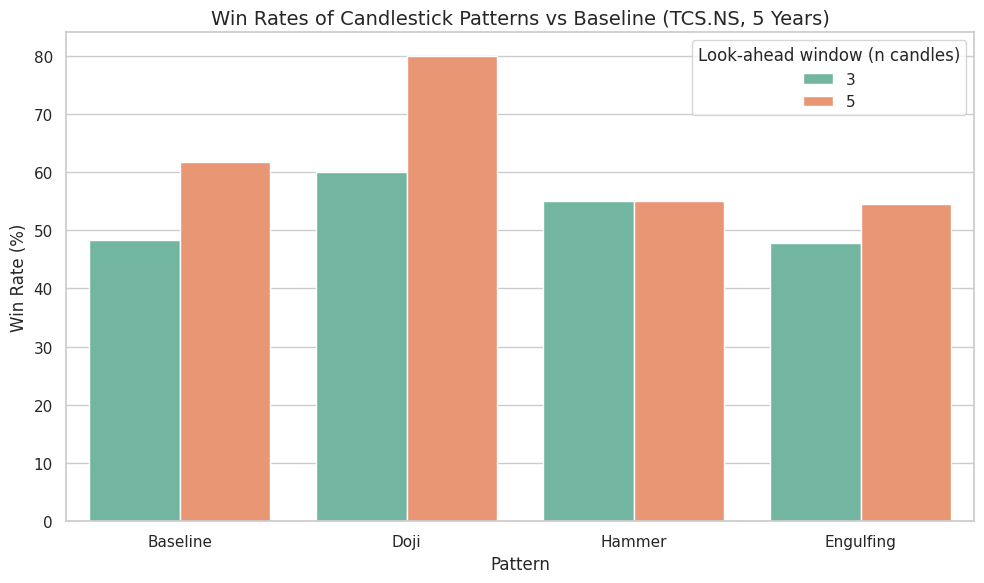

In [7]:
# Combine baseline and pattern win rate data
results_df = pd.concat([baseline_df, pattern_df], ignore_index=True)

# Plot grouped bar chart
plt.figure(figsize=(10, 6))
sns.barplot(data=results_df, x='Pattern', y='Win Rate', hue='n', palette='Set2')

plt.title(f'Win Rates of Candlestick Patterns vs Baseline ({ticker}, 5 Years)', fontsize=14)
plt.ylabel('Win Rate (%)')
plt.xlabel('Pattern')
plt.legend(title='Look-ahead window (n candles)')
plt.tight_layout()
plt.show()


### Answers

**1.Statistical Edge of Patterns**

In our experiment on TCS.NS, the Doji pattern had the highest winning percentage, particularly at n = 5. But the number of times it occurence is very less, so its statistical reliability is questionable. The Hammer pattern, in contrast, outperformed the baseline in both time windows consistently. That indicates that it possesses a more reliable edge in predicting positive returns.

**2.Effect of Changing 'n' (Look‑Ahead Window)**

Changing n affects win-rates because it changes how much time the pattern is given to succeed. A smaller n (like 3) looks for quick price moves, so it may result in lower win-rates if the price takes longer to react. A larger n (like 5) allows more time for the pattern to work, so the win-rate may increase. However, a larger n can also include more price noise or reversals, which could reduce the win-rate in some cases.Here, The Engulfing pattern had a higher win rate at n = 5 than n = 3, suggesting it would be more effective for medium-term moves. The Hammer pattern performed well in both, suggesting its efficiency is not sensitive to n.

So, increasing n can either improve or reduce win-rates depending on how quickly the pattern typically plays out.

**3.Most Consistent Performer & Why**

From results, Doji has the highest win percentage,but its extremely low frequency number makes it less reliable.However, The Hammer was the most reliable of all patterns, both maintaining high and consistent win percentages at both n = 3 and n = 5, and being frequent enough to be statistically significant. Its shape—long lower wick and small body—indicates strong rejection of lower prices, which often leads to bullish reversals that last several days.